# HDBSCAN Clustering
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py

---
Can we do this clustering with the betacov sequences?

In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics import silhouette_score, adjusted_rand_score

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../../data/betacov/betacoronavirus_seq.csv', header=0, na_filter=False)
df

,seq_id,variant,host,sequence
0,MN996532,Bat Virus,Bat,NITNLCPFGEVFNATTFASVYAWNRKRISNCVADYSVLYNSTSFST...
1,MG772934,Bat Virus,Bat,NITNVCPFHKVFNATRFPSVYAWERTKISDCIADYTVFYNSTSFST...
2,MG772933,Bat Virus,Bat,NITNVCPFHKVFNATRFPSVYAWERTKISDCIADYTVFYNSTSFST...
3,KT444582,Bat Virus,Bat,NITNLCPFGEVFNATTFPSVYAWERKRISNCVADYSVLYNSTSFST...
4,KY417146,Bat Virus,Bat,NITNLCPFGEVFNATTFPSVYAWERKRISNCVADYSVLYNSTSFST...
...,...,...,...,...
70,AKN24803.1,MERS,Human,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNFTK...
71,ASU90527.1,MERS,Camel,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTK...
72,AKL59401.1,MERS,Human,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNFKRLVFTNCNYNLTK...
73,ASY99842.1,MERS,Human,AKPSGSVVEQAEGVECDFSPLLSGTPPQVYNCKRLVFTNCNYNLTK...


In [191]:
# Pickle
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

class BetaCoVDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        self.df = pd.read_csv(csv_file, header=0, na_filter=False)

        # Calculate the maximum sequence length during initialization
        self.max_sequence_length = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):

        return self.df.iloc[idx]["seq_id"], self.df.iloc[idx]["variant"], self.df.iloc[idx]["host"], self.df.iloc[idx]["sequence"]

class ESM(nn.Module):
    def __init__(self, esm):
        super().__init__()
        self.esm = esm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            last_hidden_states = self.esm(**tokenized_seqs).last_hidden_state # shape: (batch_size, sequence_length, embedding_dim)
            cls_embedding = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)
        return cls_embedding

def extract_embedding_pickle(pickle_file:str):
    """
    Extracts seq_ids, variants, and embeddings from embedding pickle.
    """
    with open(pickle_file, 'rb') as f:
        pkl_seq_ids, pkl_variants, pkl_hosts, pkl_embeddings = pickle.load(f)

    df = pd.DataFrame({"seq_id": pkl_seq_ids,
                       "variant": pkl_variants,
                       "host": pkl_hosts,
                       "embedding": pkl_embeddings})
    return df

def run_model(model, tokenizer, dataloader, device, csv_file):   
    """ Call the BLSTM model to generate hidden states. """
    
    model = model.to(device)
    model.eval()

    # Set the tqdm progress bar
    data_iter = tqdm.tqdm(enumerate(dataloader),
                          total = len(dataloader),
                          bar_format='{l_bar}{r_bar}')

    all_seq_ids, all_variants, all_hosts, all_embeddings = [], [], [], []

    for _, batch_data in data_iter:
        seq_ids, variants, hosts, sequences = batch_data 

        # Add 2 to max_length to account for additional tokens added to beginning and end by ESM
        max_length = dataloader.dataset.max_sequence_length + 2
        tokenized_seqs = tokenizer(sequences, return_tensors='pt', padding='max_length', max_length=max_length).to(device) 
        
        with torch.no_grad():
            embeddings = model(tokenized_seqs) # shape: [batch_size, sequence_len, embedding_dim]
            
            for seq_id, variant, host, embedding in zip(seq_ids, variants, hosts, embeddings):
                all_seq_ids.append(seq_id)
                all_variants.append(variant)
                all_hosts.append(host)
                all_embeddings.append(embedding.cpu().numpy())

    embedding_matrix = np.vstack(all_embeddings)
    print(f"Stacked embedding matrix shape: {embedding_matrix.shape}")

    # Save data to a pickle file
    save_as = csv_file.replace(".csv", "-CLS_embedded.pkl")
    with open(save_as, 'wb') as f:
        pickle.dump((all_seq_ids, all_variants, all_hosts, all_embeddings), f)

# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 64

# Data file
data_dir = "../Spike_NLP_kaetlyn/data"
csv_file = os.path.join(data_dir, "betacoronavirus_seq.csv")
dataset = BetaCoVDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

model = ESM(esm)
run_model(model, tokenizer, dataloader, device, csv_file)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|| 0/2 [00:00<?, ?it/s]

100%|| 2/2 [00:00<00:00, 23.74it/s]

Stacked embedding matrix shape: (75, 320)


In [192]:
betacov_df = extract_embedding_pickle(os.path.join(data_dir, "betacoronavirus_seq-CLS_embedded.pkl"))
embedding_matrix = np.vstack(betacov_df["embedding"])
info_df = betacov_df[["seq_id", "variant", "host"]]

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

for i in [5, 10, 15, 20]:
    for j in [5, 10, 15, 20]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j
        ).fit(embedding_matrix).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 5: (Silhouette Coefficient 0.58, Adjusted Rand Index 0.55)
min_sample 5, min_cluster_size 10: (Silhouette Coefficient 0.58, Adjusted Rand Index 0.55)
min_sample 5, min_cluster_size 15: (Silhouette Coefficient 0.58, Adjusted Rand Index 0.55)
min_sample 5, min_cluster_size 20: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.47)
min_sample 10, min_cluster_size 5: (Silhouette Coefficient 0.58, Adjusted Rand Index 0.56)
min_sample 10, min_cluster_size 10: (Silhouette Coefficient 0.58, Adjusted Rand Index 0.56)
min_sample 10, min_cluster_size 15: (Silhouette Coefficient 0.58, Adjusted Rand Index 0.56)
min_sample 10, min_cluster_size 20: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.47)
min_sample 15, min_cluster_size 5: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.47)
min_sample 15, min_cluster_size 10: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.47)
min_sample 15, min_cluster_size 15: (Silhouette Coefficient 0.68, Adjusted Rand Index 0

min_sample 10, min_cluster_size 5: Silhouette Coefficient: 0.58, Adjusted Rand Index: 0.56


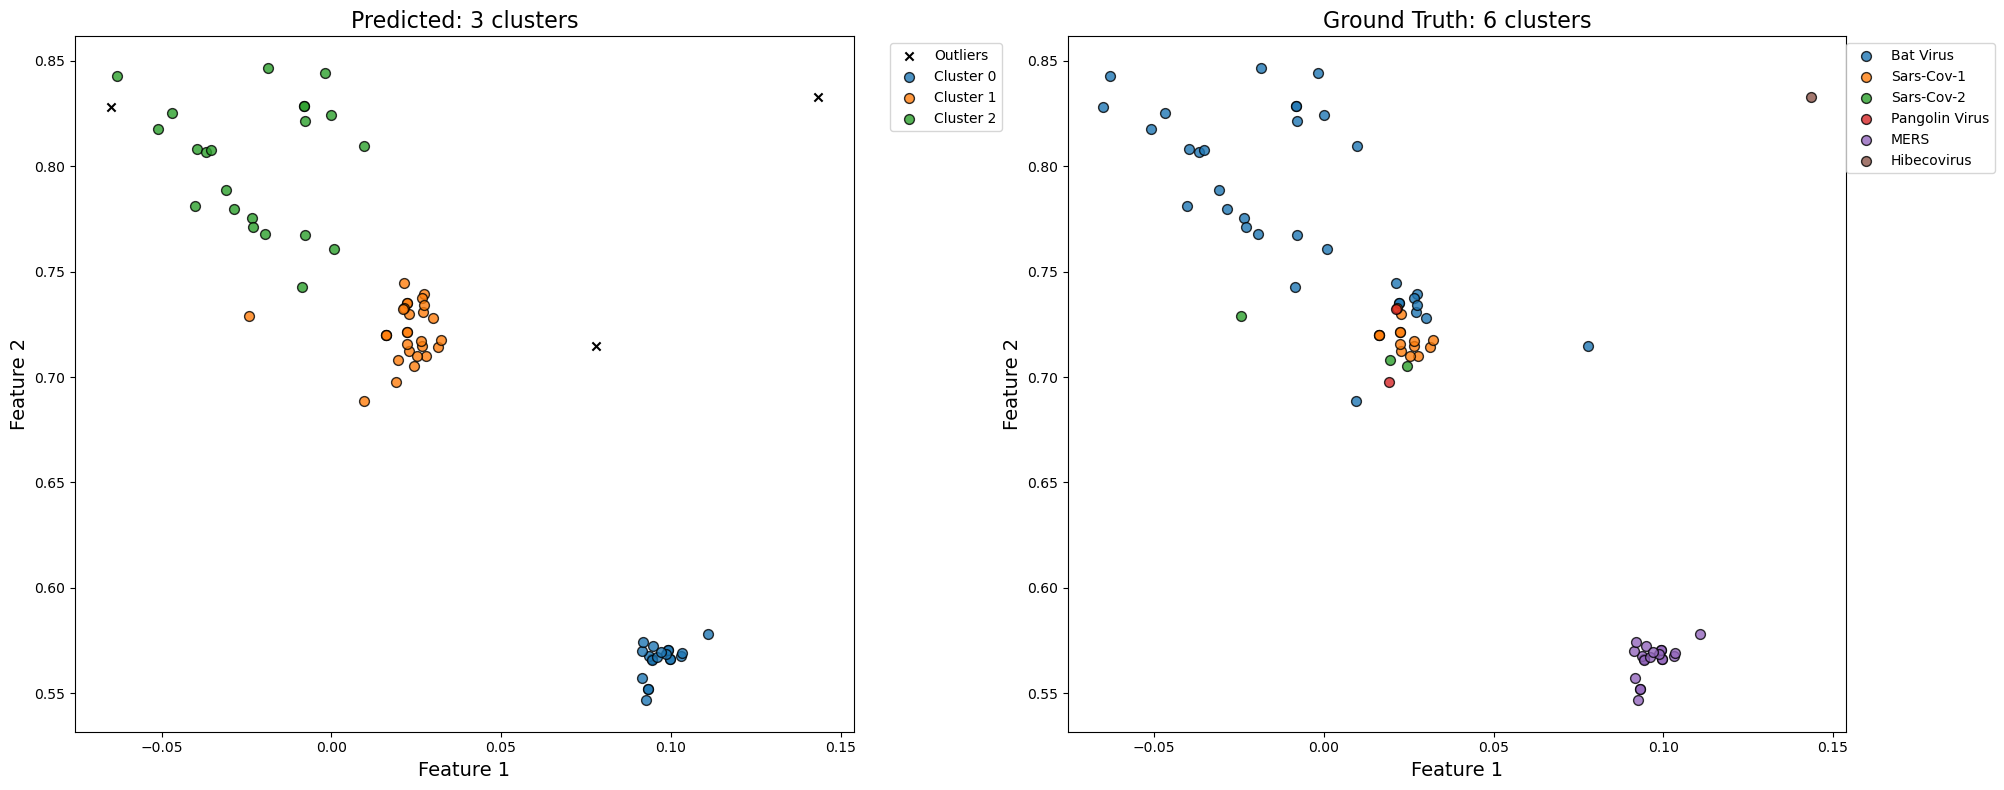

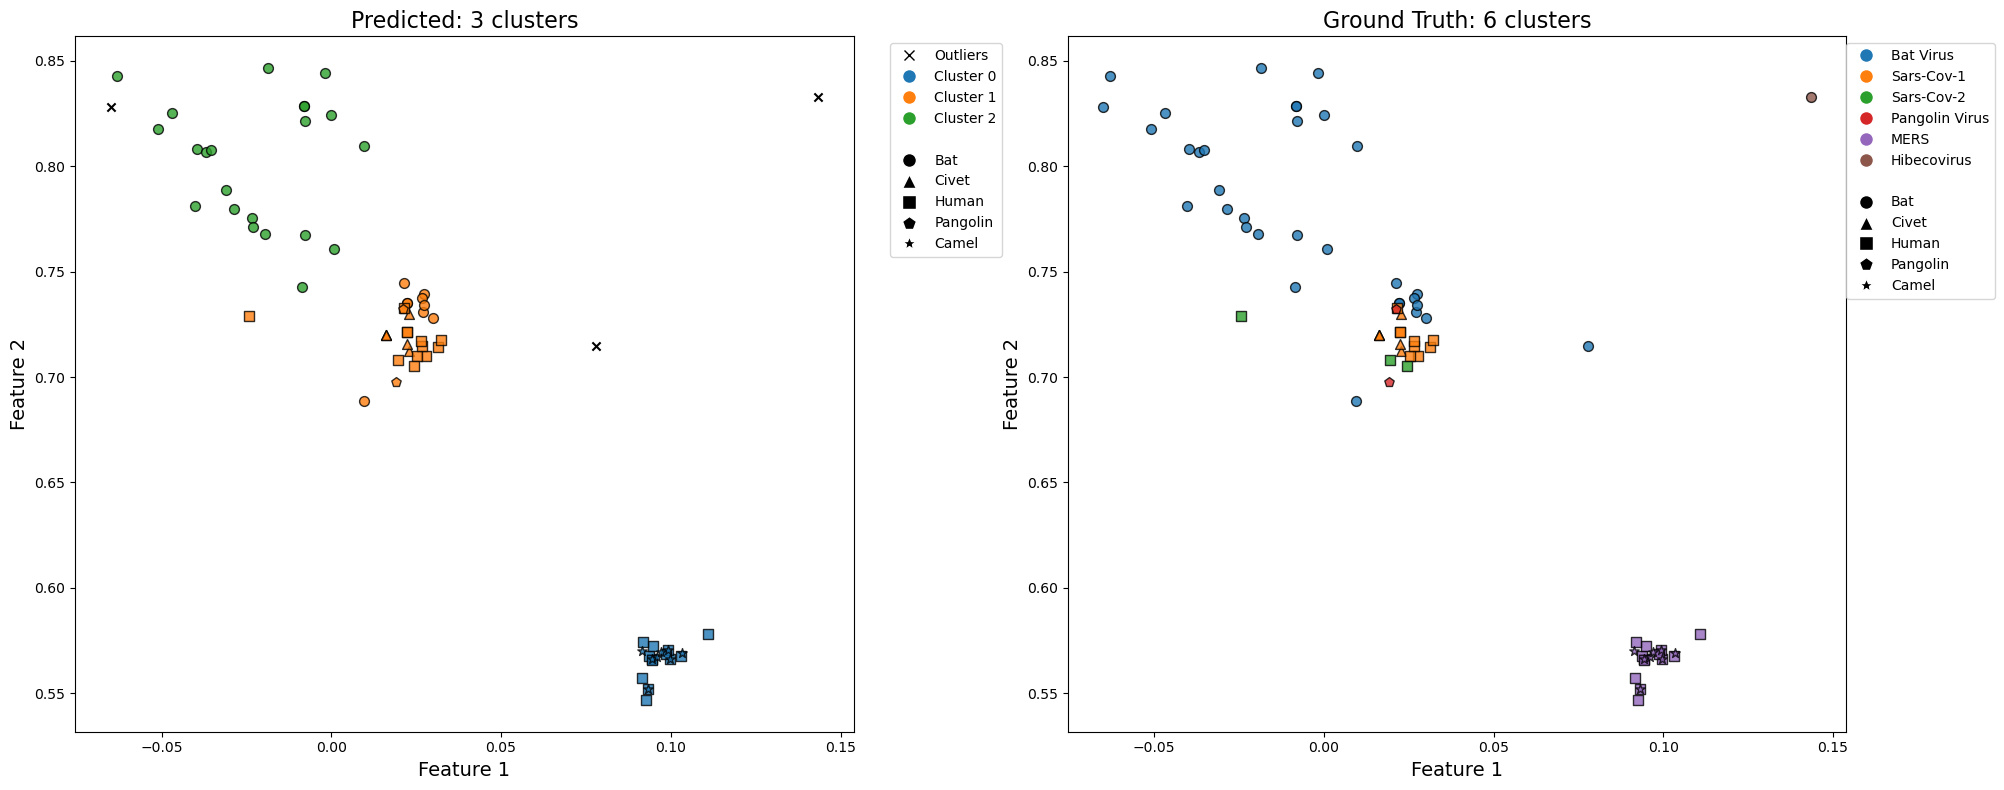

In [193]:
min_samples=10
min_cluster_size=5

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size
).fit(embedding_matrix).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")

plot_hdbscan_comparison(info_df, embedding_matrix, hdb_labels, "variant")
plot_hdbscan_with_groups(info_df, embedding_matrix, hdb_labels, "variant", "host")